In [1]:
# import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from io import StringIO
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결
import joblib

# import processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

baseDir, childDir = os.path.split(os.getcwd())
data_dir = [i.replace('\\','/') for i in glob(os.path.join(baseDir, '**', '**', '*Table.xls'))]
label = pd.read_excel(os.path.join(baseDir, 'Mechanical Test DB - Impact.xlsx'))
label['chart_name'] = label['brand'] + " | " + label['model_name'] + " | " + label['test_date'].dt.strftime('%Y-%m-%d')

sc = joblib.load('model/scaler_model.pkl')
pca    = joblib.load('model/pca_model.pkl')
kmeans = joblib.load('model/kmeans_model.pkl')

In [2]:
DATA = {}
for f in data_dir:
# 파일을 텍스트 형식으로 읽기
    with open(f, 'r', encoding='cp949') as file:
        lines = file.readlines()

        # 'Time' 행 이후의 데이터만 추출
        start_index = next(i for i, line in enumerate(lines) if 'Trial' in line)
        end_index = next(i for i, line in enumerate(lines) if 'Ave' in line)
        data_subset = lines[start_index:end_index]
        # 리스트를 문자열로 결합
        data_str = ''.join(data_subset)

        # StringIO를 사용해 데이터프레임으로 변환
        df = pd.read_csv(StringIO(data_str), delimiter='\t')
        df = df[~df['Trial'].str.contains('=+', na=False)].astype(float)
        df['force/pen (N/mm)'] = df['Force (N)'] / df['Max Pen (mm)']
        DATA[os.path.splitext(os.path.basename(f))[0]] = np.mean(df,axis=0)
        
        
chart_to_files = {}

# 폴더명에서 숫자 부분 추출 및 chart_name과 매칭
for folder in sorted(DATA.keys()):
    folder_num = folder.split('_')[0]
    
    # 매칭되는 chart_name을 찾기
    matching_row = label[label['shoe_num'].astype(str) == folder_num][['chart_name', 'category', 'shoe_mass']]
    
    if not matching_row.empty:
        chart_name = matching_row['chart_name'].values[0]
        
        # 해당 폴더 내의 모든 파일 경로를 리스트로 가져오기
        # 여기서는 폴더 경로를 사용해 모든 파일을 검색
        ff_file = []
        rf_file = []
        files_in_folder = [i for i in sorted(DATA.keys()) if folder_num in i][:2]
        if files_in_folder:
            for file in files_in_folder:
                if 'FF' in file:
                    ff_file = file
                elif 'RF' in file:
                    rf_file = file
            files_in_folder = [ff_file, rf_file]
        chart_to_files[chart_name] = files_in_folder, matching_row
        
DF = pd.DataFrame()
for chart in chart_to_files:
    try:
        FORE = pd.DataFrame(DATA[chart_to_files[chart][0][0]]).T.iloc[:,[4,8,9]]
        REAR = pd.DataFrame(DATA[chart_to_files[chart][0][1]]).T.iloc[:,[4,8,9]]
        # FORE = pd.DataFrame(DATA[chart_to_files[chart][0][0]]).T.iloc[:,1:]
        # REAR = pd.DataFrame(DATA[chart_to_files[chart][0][1]]).T.iloc[:,1:]
        LABEL = chart_to_files[chart][1].copy()
        LABEL = LABEL.reset_index(drop=True)
        FORE.columns = FORE.columns.str.replace(')', ') ForeFoot')
        REAR.columns = REAR.columns.str.replace(')', ') RearFoot')
        df = pd.concat([LABEL, FORE, REAR],axis=1)
    
    except Exception as e:
        # print(chart)
        pass

    DF = pd.concat([DF, df])

In [3]:
df = DF[DF['category'] == 'RUNNING'].reset_index(drop=True)

data = df.copy()
num_cols = data.columns[3:]
df_num = data[num_cols]

In [4]:
df_num_arr = sc.transform(df_num)
df_num_sc = pd.DataFrame(df_num_arr, columns = num_cols)
pca_arr = pca.transform(df_num_sc)


pca_col = [f"pca_component_{i+1}" for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca_arr, columns=pca_col)
PCA_DF = pd.concat([data.iloc[:,:2],df_num_sc, df_pca], axis=1)

X =PCA_DF[['pca_component_1','pca_component_2','pca_component_3','pca_component_4']]
y_pred = kmeans.predict(X)
labels = y_pred + 1
PCA_DF['labels'] = labels
centroids = kmeans.cluster_centers_

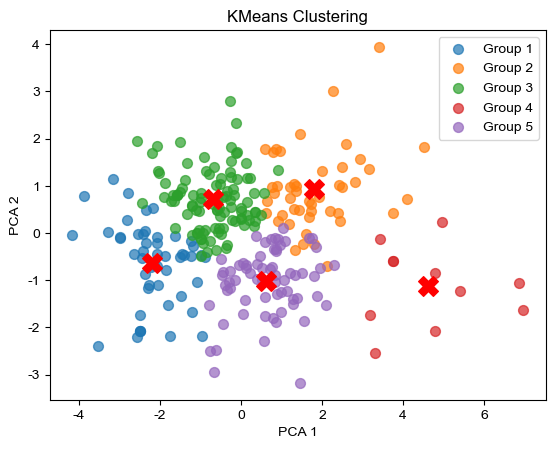

In [5]:
# 각 클러스터의 데이터를 개별적으로 시각화
for i in range(1, 6):  # 클러스터가 1부터 시작하므로
    cluster_data = X[labels == i]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Group {i}', alpha=0.7, s=50)

# 클러스터 중심점(Centroids) 시각화
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', s=200, marker='X'
)

plt.title("KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
# plt.savefig(f'{baseDir}/image/clustring.png',dpi=300)
plt.show()